In [1]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
def T_norm(percentage):
    return 1.1081*1e-4 * np.square(percentage) + 0.0092 * percentage - 0.00934

def inch2m(value):
    return value * 0.0254

def V_in(perc_RPM, RPM_max, pitch):
    return (RPM_max * (perc_RPM/100) * pitch/60)

def w_rot(perc_RPM, RPM_max):
    return (2*np.pi/60) * RPM_max * perc_RPM / 100

In [3]:
# données
data_path = os.path.join(os.getcwd(), 'data')
CG_data = scipy.io.loadmat(os.path.join(data_path, 'CG_data.mat'))

picth_inch = 4
d_inch = 5
rho = 1.225

pitch_m = inch2m(picth_inch)
d_m = inch2m(d_inch)
S_ref = np.pi * np.square(d_m) / 4
RPM_max = 30000

-0.36683530636315453


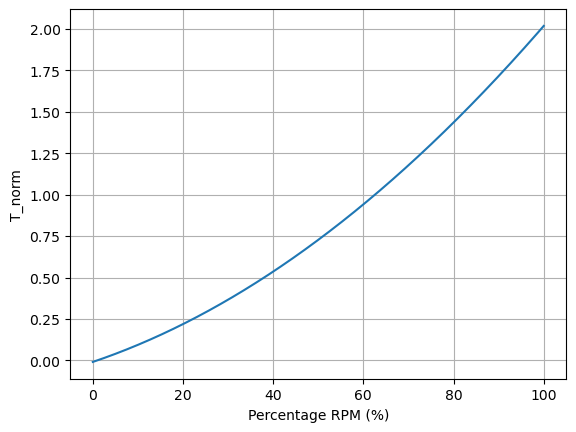

In [4]:
percentage = np.linspace(0, 100, 1000)
T_norme = T_norm(percentage=percentage)

V_in_vector = V_in(percentage, RPM_max, pitch_m)

plt.plot(percentage, T_norme)
plt.grid("on")
plt.xlabel('Percentage RPM (%)')
plt.ylabel('T_norm')

C_L = T_norme[1:] / (0.5 * rho * np.square(V_in_vector[1:]) * S_ref)
print(np.mean(C_L))

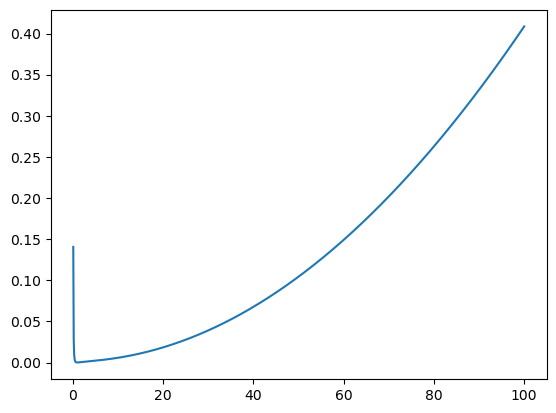

In [5]:
# estimation du coefficient de traînée de l'hélice
AR = 10 # AR = d_m/(~0.1d_m)
e = 0.8 # bien souvent compris entre 0.7 et 0.9

k = 1 / (np.pi * e * AR)

C_Do = 0.02
C_D = C_Do + k * np.square(C_L)

D = C_D * 0.5 * rho * S_ref * np.square(V_in_vector[1:])

plt.plot(percentage[1:], D)

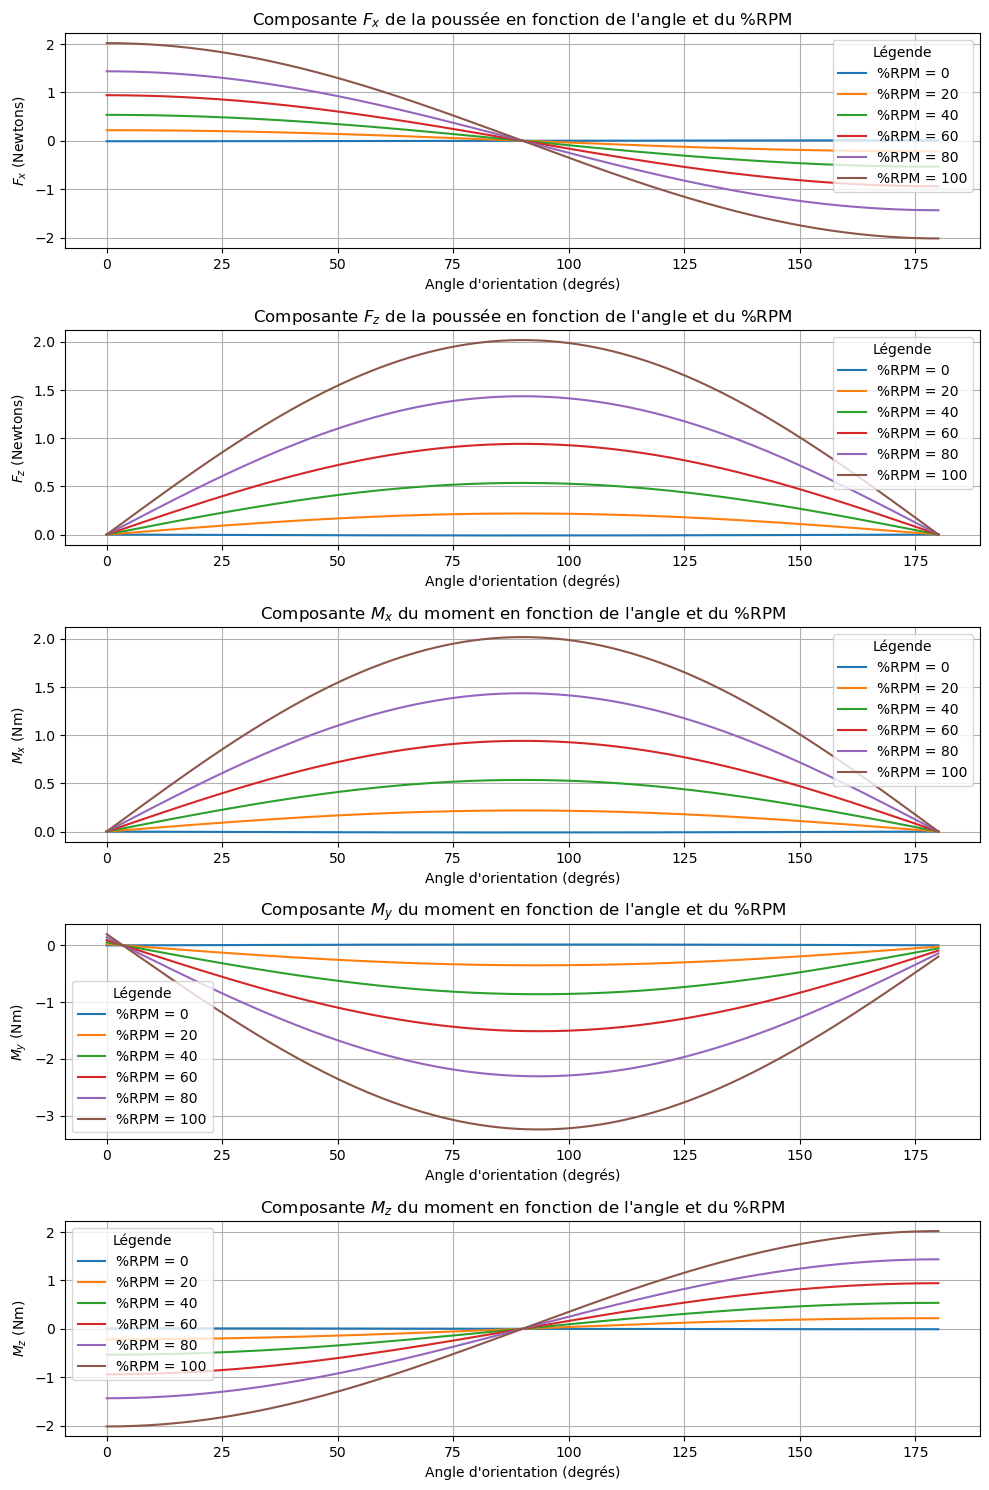

In [6]:
CG_dirigeable = CG_data['CG_total'][0]
CG_motor = CG_data['CG_motor']
d_AvD_CG = CG_dirigeable - CG_motor[0] # shape(1, 3)

alpha = np.linspace(0, np.pi, 180)

fig, axs = plt.subplots(5, 1, figsize=(10, 15))
percRPM = [0, 20, 40, 60, 80, 100]

for index, percent_rpm in enumerate(percRPM):
    # moteur avant droit
    sens_rotation = -1

    F = T_norm(percent_rpm)
    Fx = F * np.cos(alpha)
    Fz = F * np.sin(alpha)

    F_vector = np.array([Fx, np.zeros_like(Fx), Fz])
    
    M = sens_rotation * np.cross(d_AvD_CG[:, np.newaxis], F_vector, axis=0) 
    
    axs[0].plot(alpha * 180 / np.pi, Fx, label=f'%RPM = {percent_rpm}')
    axs[1].plot(alpha * 180 / np.pi, Fz, label=f'%RPM = {percent_rpm}')
    axs[2].plot(alpha * 180 / np.pi, M[0], label=f'%RPM = {percent_rpm}')
    axs[3].plot(alpha * 180 / np.pi, M[1], label=f'%RPM = {percent_rpm}')
    axs[4].plot(alpha * 180 / np.pi, M[2], label=f'%RPM = {percent_rpm}')

axs[0].set_title('Composante $F_x$ de la poussée en fonction de l\'angle et du %RPM')
axs[0].set_xlabel('Angle d\'orientation (degrés)')
axs[0].set_ylabel('$F_x$ (Newtons)')
axs[0].grid(True)
axs[0].legend(title='Légende')

axs[1].set_title('Composante $F_z$ de la poussée en fonction de l\'angle et du %RPM')
axs[1].set_xlabel('Angle d\'orientation (degrés)')
axs[1].set_ylabel('$F_z$ (Newtons)')
axs[1].grid(True)
axs[1].legend(title='Légende')

axs[2].set_title('Composante $M_x$ du moment en fonction de l\'angle et du %RPM')
axs[2].set_xlabel('Angle d\'orientation (degrés)')
axs[2].set_ylabel('$M_x$ (Nm)')
axs[2].grid(True)
axs[2].legend(title='Légende')

axs[3].set_title('Composante $M_y$ du moment en fonction de l\'angle et du %RPM')
axs[3].set_xlabel('Angle d\'orientation (degrés)')
axs[3].set_ylabel('$M_y$ (Nm)')
axs[3].grid(True)
axs[3].legend(title='Légende')

axs[4].set_title('Composante $M_z$ du moment en fonction de l\'angle et du %RPM')
axs[4].set_xlabel('Angle d\'orientation (degrés)')
axs[4].set_ylabel('$M_z$ (Nm)')
axs[4].grid(True)
axs[4].legend(title='Légende')

plt.tight_layout()
plt.show()

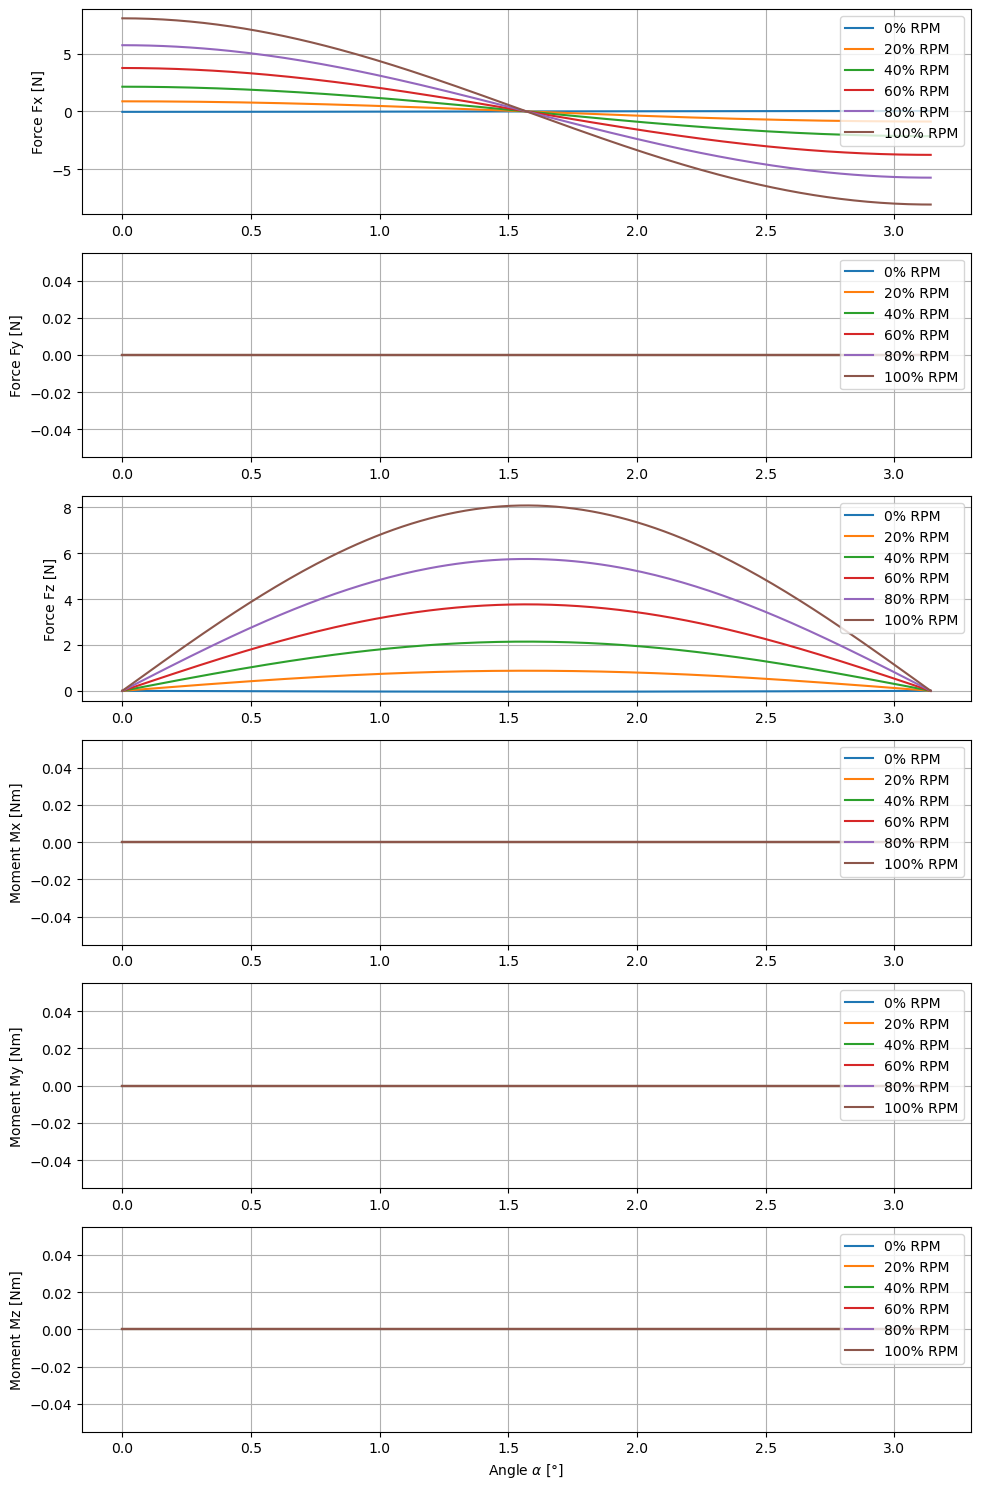

In [7]:
# expression de la résultante des forces et des moments

alpha = np.linspace(0, np.pi, 180)

# fig, axs = plt.subplots(5, 1, figsize=(10, 15))
percRPM = [0, 20, 40, 60, 80, 100]
distance = np.array([CG_dirigeable - CG_motor[motor] for motor in range(4)])

# Initialisation des graphiques
fig, axs = plt.subplots(6, 1, figsize=(10, 15))

for index, percent_rpm in enumerate(percRPM):
    forces_total = np.zeros((3, len(alpha)))
    moments_total = np.zeros((3, len(alpha)))

    for motor in range(4):
        if motor in [0, 3]:
            sens_rotation = 1
        else:
            sens_rotation = -1
        
        F = T_norm(percent_rpm)
        Fx = F * np.cos(alpha)
        Fz = F * np.sin(alpha)

        F_vector = np.array([Fx, np.zeros_like(Fx), Fz])
        
        M = sens_rotation * np.cross(distance[motor][:, np.newaxis], F_vector, axis=0) 
        
        forces_total += F_vector
        moments_total += M

    axs[0].plot(alpha, forces_total[0], label=f'{percent_rpm}% RPM')
    axs[1].plot(alpha, forces_total[1], label=f'{percent_rpm}% RPM')
    axs[2].plot(alpha, forces_total[2], label=f'{percent_rpm}% RPM')
    axs[3].plot(alpha, moments_total[0], label=f'{percent_rpm}% RPM')  
    axs[4].plot(alpha, moments_total[1], label=f'{percent_rpm}% RPM') 
    axs[5].plot(alpha, moments_total[2], label=f'{percent_rpm}% RPM')

# Étiquettes et légendes
axs[0].set_ylabel('Force Fx [N]')
axs[1].set_ylabel('Force Fy [N]')
axs[2].set_ylabel('Force Fz [N]')
axs[3].set_ylabel('Moment Mx [Nm]')
axs[4].set_ylabel('Moment My [Nm]')
axs[5].set_ylabel('Moment Mz [Nm]')
axs[5].set_xlabel(r'Angle $\alpha$ [°]')

for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()